In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    precision_score,
    recall_score,
    roc_auc_score,
    confusion_matrix,
)
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_excel("dataset.xlsx")

## Exploration

Let us just see how many instances of positive and negative data points we have:

In [3]:
df.groupby("SARS-Cov-2 exam result").count()

,Patient ID,Patient age quantile,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Serum Glucose,Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Mycoplasma pneumoniae,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,Neutrophils,Urea,Proteina C reativa mg/dL,Creatinine,Potassium,Sodium,"Influenza B, rapid test","Influenza A, rapid test",Alanine transaminase,Aspartate transaminase,Gamma-glutamyltransferase,Total Bilirubin,Direct Bilirubin,Indirect Bilirubin,Alkaline phosphatase,Ionized calcium,Strepto A,Magnesium,pCO2 (venous blood gas analysis),Hb saturation (venous blood gas analysis),Base excess (venous blood gas analysis),pO2 (venous blood gas analysis),Fio2 (venous blood gas analysis),Total CO2 (venous blood gas analysis),pH (venous blood gas analysis),HCO3 (venous blood gas analysis),Rods #,Segmented,Promyelocytes,Metamyelocytes,Myelocytes,Myeloblasts,Urine - Esterase,Urine - Aspect,Urine - pH,Urine - Hemoglobin,Urine - Bile pigments,Urine - Ketone Bodies,Urine - Nitrite,Urine - Density,Urine - Urobilinogen,Urine - Protein,Urine - Sugar,Urine - Leukocytes,Urine - Crystals,Urine - Red blood cells,Urine - Hyaline cylinders,Urine - Granular cylinders,Urine - Yeasts,Urine - Color,Partial thromboplastin time (PTT),Relationship (Patient/Normal),International normalized ratio (INR),Lactic Dehydrogenase,"Prothrombin time (PT), Activity",Vitamin B12,Creatine phosphokinase (CPK),Ferritin,Arterial Lactic Acid,Lipase dosage,D-Dimer,Albumin,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
SARS-Cov-2 exam result,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
negative,5086,5086,5086,5086,5086,520,520,519,518,519,519,519,519,519,519,519,519,518,519,175,1242,1242,1242,1240,1240,1240,0,1240,1240,1240,1240,1240,1240,1240,1240,1240,1240,1240,438,338,436,362,313,312,758,758,185,186,123,142,142,142,115,44,318,35,116,116,116,116,1,116,116,116,88,88,88,88,88,88,49,58,58,58,58,48,1,58,57,50,0,58,58,58,56,57,58,58,0,76,110,75,0,3,81,21,14,5,0,13,14,14,14,14,14,14,14,11,19,14
positive,558,558,558,558,558,83,83,83,81,83,83,83,83,83,83,83,83,83,83,33,112,112,112,112,112,112,0,112,112,112,112,112,112,112,112,112,112,112,75,59,70,62,58,58,62,62,40,40,30,40,40,40,29,6,14,5,20,20,20,20,0,20,20,20,9,9,9,9,9,9,11,12,12,12,12,9,0,12,12,10,0,12,12,12,11,12,12,12,0,15,23,26,0,0,23,2,13,3,0,0,13,13,13,13,13,13,13,9,1,13


Let's manually explore the dataset, and see what types of values we see in each column.

In [20]:
#for column in df.columns:
#    print(column)
#    print(df[column].unique())

In [5]:
# Let's drop columns that do not give clinical information about the patient
no_information = [
    "Patient ID", 
    "Patient addmited to regular ward (1=yes, 0=no)", 
    "Patient addmited to semi-intensive unit (1=yes, 0=no)",
    "Patient addmited to intensive care unit (1=yes, 0=no)"]
df = df.drop(no_information, axis=1)

In [6]:
# Let's drop features that, for some reason, are empty or only contain empty data points
features_to_drop = [
    "Mycoplasma pneumoniae", # it is always NA
    "Fio2 (venous blood gas analysis)", # NA or 0
    "Myeloblasts", # NA or 0
    "Urine - Nitrite", # absent or not done
    "Urine - Urobilinogen", # nan, normal, not done
    "Urine - Protein", # nan, normal, not done
    "Urine - Sugar", # na
    "Urine - Hyaline cylinders", # na or absent,
    "Urine - Granular cylinders", # na or absent,
    "Urine - Yeasts", # na absent
    "Partial thromboplastin time (PTT) ", # nan
    "Prothrombin time (PT), Activity", # nan
    "D-Dimer", # nan
]
df = df.drop(features_to_drop, axis=1)

In [7]:
# some columns need encoding
columns_that_need_encoding = [
    "Respiratory Syncytial Virus",
    "Influenza A",
    "Influenza B",
    "Parainfluenza 1",
    "CoronavirusNL63",
    "Rhinovirus/Enterovirus",
    "Coronavirus HKU1",
    "Parainfluenza 3",
    "Chlamydophila pneumoniae",
    "Adenovirus",
    "Parainfluenza 4",
    "Coronavirus229E",
    "CoronavirusOC43",
    "Inf A H1N1 2009",
    "Bordetella pertussis",
    "Metapneumovirus",
    "Parainfluenza 2",
    "Influenza B, rapid test",
    "Influenza A, rapid test",
    "Strepto A",
    "Urine - Esterase",
    "Urine - Aspect",
    "Urine - Hemoglobin",
    "Urine - Bile pigments",
    "Urine - Ketone Bodies",
    "Urine - Crystals",
    "Urine - Color",
]

# some columns have value written in PT-BR
df["Urine - Crystals"].replace("Ausentes", "absent", inplace=True)
# TODO: I do not know how to translate the following: Urato Amorfo and Oxalato de Cálcio

# Let's get the names of numerical columns, before we change the categorical ones
numerical_columns = list(df.columns)
for column in columns_that_need_encoding:
    numerical_columns.remove(column)
numerical_columns.remove("SARS-Cov-2 exam result")

for column in columns_that_need_encoding:
    df[column].replace(float('NaN'), "RESULT ABSENT", inplace=True)
    df = pd.get_dummies(df, columns=[column])

In [8]:
# replace all missing NAs by a very large and different value from the others
df["Urine - pH"].replace("Não Realizado", float("NaN"), inplace=True)
df = df.fillna(-9999)

# Replace this strange <1000 to 999
df["Urine - Leukocytes"].replace("<1000", 999, inplace=True)

In [9]:
# predicted label as simple integets
df["SARS-Cov-2 exam result"].replace("positive", 1, inplace=True)
df["SARS-Cov-2 exam result"].replace("negative", 0, inplace=True)

In [10]:
df.to_excel("dataset-clean.xlsx")

## Building models

In [11]:
def _extract_feature_importance(model, features):
    if not hasattr(model, "coef_") and not hasattr(model, "feature_importances_"):
        raise Exception("Not possible to collect feature importances")

    if hasattr(model, "coef_"):
        model_feature_importances = model.coef_[0]
    elif hasattr(model, "feature_importances_"):
        model_feature_importances = model.feature_importances_

    return [
        (feature, importance)
        for feature, importance in sorted(
            zip(features, model_feature_importances),
            key=lambda pair: pair[1],
            reverse=True,
        )
    ]

def run(X_train, y_train, X_test, y_test):

    SEARCH_ITERATIONS = 200
    K_FOLD_ITERATIONS = 5

    params_to_tune = {
        "max_depth": [3, 6, 12, 24, None],
      "max_features": ["auto", "sqrt", "log2", None],
      "min_samples_split": [2, 3, 4, 5, 10],
      "bootstrap": [True, False],
      "criterion": ["gini", "entropy"],
      "n_estimators": [10, 50, 100, 150, 200]}

    search = GridSearchCV(
        RandomForestClassifier(), 
        params_to_tune, 
        #n_iter=SEARCH_ITERATIONS, 
        scoring=["precision", "recall", "roc_auc"],
        refit="roc_auc",
        cv=StratifiedKFold(
            n_splits=K_FOLD_ITERATIONS, 
            shuffle=True),  
        n_jobs=-1)
    
    search.fit(X_train, y_train)
    
    model = search.best_estimator_

    predictions = model.predict(X_test)

    idx = search.best_index_
    scores_cv = pd.DataFrame(search.cv_results_).iloc[idx]
    metrics = {"prec": "test_precision", "rec": "test_recall", "roc": "test_roc_auc"}
    cv_results = {
        k: (scores_cv["mean_" + v], scores_cv["std_" + v]) for k, v in metrics.items()
    }
    test_results = {
        "prec": precision_score(y_test, predictions),
        "rec": recall_score(y_test, predictions),
        "roc": roc_auc_score(y_test, predictions),
    }

    cm = confusion_matrix(y_test, predictions)
    
    feature_importance = _extract_feature_importance(model, X_train.columns.values)
    return search, model, cv_results, cm, feature_importance
    

### All the features

In [12]:
X = df.drop("SARS-Cov-2 exam result", axis=1)
y = df["SARS-Cov-2 exam result"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(y_train.value_counts())
print(y_test.value_counts())

0    4065
1     450
Name: SARS-Cov-2 exam result, dtype: int64
0    1021
1     108
Name: SARS-Cov-2 exam result, dtype: int64


In [13]:
search, model, cv_results, cm, feature_importance = run(X_train, y_train, X_test, y_test)

In [14]:
cv_results

{'prec': (0.5461904761904762, 0.277679075434647),
 'rec': (0.03333333333333333, 0.018592445034090566),
 'roc': (0.6756252562525625, 0.023558438218614603)}

In [15]:
cm

array([[1018,    3],
       [ 105,    3]])

<BarContainer object of 27 artists>

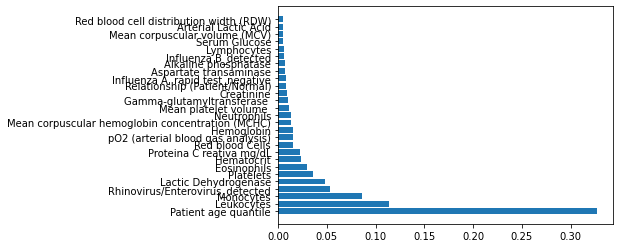

In [16]:
pd_fi = pd.DataFrame(feature_importance, columns=["feature", "importance"])
pd_fi = pd_fi[(pd_fi.importance > 0.005)]

plt.barh(pd_fi["feature"], pd_fi["importance"])